# Simpson's paradox

![SegmentLocal](simpson.gif "segment")

### Standard import

In [25]:
import numpy as np  # For maths
import pandas as pd  # For data frames
import matplotlib.pyplot as plt  # For plots
import seaborn as sns  # For nice plots
from matplotlib.ticker import FuncFormatter  # To format % in axis
from IPython.core.display import display, HTML  # For nice display of data frames

### Copy to local data (if not there already)

In [2]:
data_url = "https://gitlab.inria.fr/learninglab/mooc-rr/mooc-rr-ressources/-/raw/master/module3/Practical_session/Subject6_smoking.csv"

data_file = "smoking_data.csv"

import os
import urllib.request
if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)

### Load data 

In [3]:
raw_data = pd.read_csv(data_file)
raw_data.head()

Smoker Status   Age
0    Yes  Alive  21.0
1    Yes  Alive  19.3
2     No   Dead  57.5
3     No  Alive  47.1
4    Yes  Alive  81.4

### Preprocessing

Check that "Smoker" and "Satus" have only two possible values

In [4]:
raw_data["Smoker"].unique(), raw_data["Status"].unique()

(array(['Yes', 'No'], dtype=object), array(['Alive', 'Dead'], dtype=object))

Convert them to boolean for a more standardised analysis downstream.
In particular, there is no missing values for those (otherwise they would show as NaN or some other tag). Also, rename "Status" for clarity.

In [5]:
df = raw_data.copy()
 
df["Smoker"] = df["Smoker"] == "Yes"
df["Status"] = df["Status"] == "Dead"

df.rename(columns={"Status": "Dead"}, inplace=True)

df.head()

Smoker   Dead   Age
0    True  False  21.0
1    True  False  19.3
2   False   True  57.5
3   False  False  47.1
4    True  False  81.4

Check for missing values in "Age".

In [6]:
print("{:.0f} missing value(s) in 'Age'".format(df["Age"].isna().sum()))    

0 missing value(s) in 'Age'


## 1. Mortality rates among smokers vs. non-smokers

First, group by "Smoker"

In [7]:
df_by_smoker = df.groupby(by=["Smoker"])

Number of deaths

In [8]:
df_by_smoker.sum()[["Dead"]].astype(int)

Dead
Smoker      
False    230
True     139

Total number per class (smokers vs. non-smokers)

In [9]:
df_by_smoker.count()[["Dead"]].astype(int)

Dead
Smoker      
False    732
True     582

Mortality rate (ratio of dead / number within the class)

In [10]:
display(
    HTML(
        df_by_smoker.mean()[["Dead"]].to_html(formatters={"Dead": "{:,.1%}".format})
    )
)

### Visualisation

We summarise these results using a bar plot. The black lines represent 95% confidence intervals around the mean mortality rates.

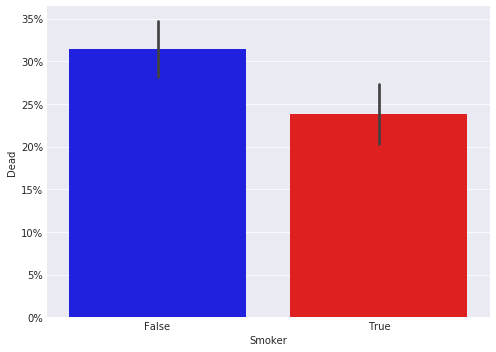

In [49]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)

    sns.barplot(data=df, x="Smoker", y="Dead", ax=ax, ci=95, palette=("blue", "red"))  # Note: in recent versions of seaborn, we should rather use errorbar=('ci', 95).

    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    plt.tight_layout()
    plt.show()

At first, this is surprising: the mortality rate appears to be lower in the smoker group.

To confirm this, let's perform a statistical test (this is actually equivalent to the confidence intervals suggested in the question). A simple t-test will do (although it is not the most appropriate here -- categorical data -- it is simple and it is not the focus of this exercise).

In [40]:
from scipy.stats import ttest_ind

df_smoker = df[df["Smoker"]]
df_nonsmoker = df[~df["Smoker"]]
ttest_ind(df_smoker["Dead"], df_nonsmoker["Dead"], equal_var=False)

Ttest_indResult(statistic=-3.057733462432345, pvalue=0.002276255348902961)

The p-value is less than 0.05, i.e. we reject (at significance level 95%) the null hypothesis that both smokers and non-smokers have the same mortality rate.

**Conclusion**: the mortality rate among smokers is significantly lower than among nonsmokers.

## 2. Mortality rates among smokers vs. non-smokers by age class

First, let us split the data frame in four age classes: 18-34, 35-54, 55-64, 65+. To this end, let us use a function.

In [83]:
def get_age_class(age):
    if age < 18:
        return "18-"  # To check that we do not have age < 18
    elif age <= 34:
        return "18-34"
    elif age <= 54:
        return "35-54"
    elif age <= 64:
        return "55-64"
    else:
        return "65+"


df["Age_class"] = df["Age"].apply(get_age_class)  # Remark: this is kind of slow, but it is clear and it will do for this simple analysis.
age_classes = np.sort(df["Age_class"].unique())

Check that nobody is younger than 18

In [84]:
print("{:.0f} individual(s) younger than 18".format((df["Age_class"] == "18-").sum()))

0 individual(s) younger than 18


Display the mean mortality rates split by age class

In [85]:
display(
    HTML(
        df.groupby(by=["Age_class", "Smoker"]).mean()[["Dead"]].to_html(formatters={"Dead": "{:,.1%}".format})
    )
)

## Visualisation

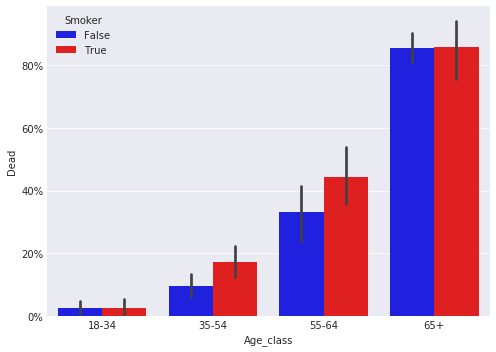

In [88]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)

    sns.barplot(data=df, x="Age_class", y="Dead", hue="Smoker", ax=ax, ci=95, palette=("blue", "red"), order=tuple(age_classes))  # Note: in recent versions of seaborn, we should rather use errorbar=('ci', 95).

    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    plt.tight_layout()
    plt.show()

Redo the statistical tests

In [58]:
df_smoker = df[df["Smoker"]]
df_nonsmoker = df[~df["Smoker"]]

for age_class in age_classes:
    df_smoker_age_class = df_smoker[df_smoker["Age_class"] == age_class]
    df_nonsmoker_age_class = df_nonsmoker[df_nonsmoker["Age_class"] == age_class]
    print(ttest_ind(df_smoker_age_class["Dead"], df_nonsmoker_age_class["Dead"], equal_var=False))

Ttest_indResult(statistic=0.013780528783028018, pvalue=0.9890122465905076)
Ttest_indResult(statistic=1.783075769977916, pvalue=0.07588466008529735)
Ttest_indResult(statistic=2.4009857289248324, pvalue=0.01677328896330688)
Ttest_indResult(statistic=0.03927297913991199, pvalue=0.9687782291030265)


**Conclusion**: when inspecting by age class, the conclusion is reversed, i.e. within each age class, the mortality rate is higher among smokers. 

Note that this increase of mortality rate is not significant for the youngest and oldest age classes ($p\gg0.05$). This is intuitive: tobacco-related health conditions take many years to develop, therefore they do not significantly impact the mortality rate of young people. On the other hand, the elderly suffer from many possible health threats that are unrelated to their smoking status, which tend to erase disparities between smokers and non-smokers. 

For the other two age classes (35-54 and 55-64), the increases of mortality rates are respectively weakly significant ($p=0.076$) and significant ($p=0.017$). In particular, this last class comprises aging people for which a lifetime of smoking may is likely to have had the time to trigger tobacco-related conditions.

### Why is it seemingly contradictory with the age-agnostic analysis of question 1?

In this study, $Age$ is a typical *confounding* variable. In simple terms, $Age$ conditions the distributions of the $Smoker$ variable. In the figure below, we report the percentage of smokers per age class.

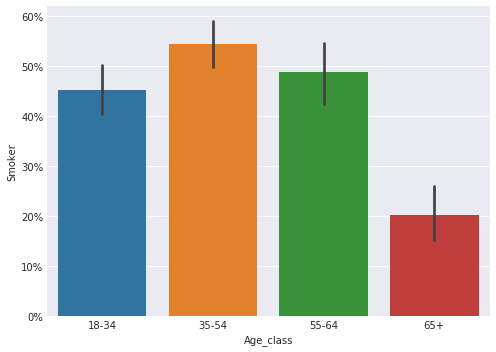

In [89]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(7, 5), nrows=1, ncols=1)

    sns.barplot(data=df, x="Age_class", y="Smoker", ax=ax, ci=95, order=tuple(age_classes))  # Note: in recent versions of seaborn, we should rather use errorbar=('ci', 95).

    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    plt.tight_layout()
    plt.show()

We see that smokers are underrepresented among the elderly compared to the other three age classes (probably because many long-time smokers quit when they grow old and start developing tobacco-related health conditions). Therefore, in the overall analysis of question 1, $Age$ acted as a proxy for the absence of smoking habit. Since the mean mortality rate is higher among the elderly (irrespective of the cause -- after all, they may simply die of old age), this creates a spurious negative correlation between $Smoker$ and $Dead$ (non-smokers are more likely older, and thus more likely to have a high mortality rate). 

## 3. Mortality rates among smokers vs. non-smokers by age using logistic regression

We perform a logistic regression for the model $Dead \sim Age$

In [70]:
import statsmodels.api as sm

log_reg = sm.Logit(df["Dead"], df[["Age", "Smoker"]].astype(int)).fit()

log_reg_smoker = sm.Logit(df_smoker["Dead"], df_smoker["Age"]).fit()
log_reg_nonsmoker = sm.Logit(df_nonsmoker["Dead"], df_nonsmoker["Age"]).fit()

Optimization terminated successfully.
         Current function value: 0.629619
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.633082
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.687904
         Iterations 3


In [71]:
log_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Dead   No. Observations:                 1314
Model:                          Logit   Df Residuals:                     1312
Method:                           MLE   Df Model:                            1
Date:                Tue, 26 Sep 2023   Pseudo R-squ.:                -0.06045
Time:                        21:06:14   Log-Likelihood:                -827.32
converged:                       True   LL-Null:                       -780.16
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0002      0.001      0.112      0.911      -0.002       0.003
Smoker        -1.1657      0.114    -10.253      0.000      -1.389      -0.943
==============================================================================
"""

In [72]:
log_reg_smoker.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Dead   No. Observations:                  582
Model:                          Logit   Df Residuals:                      581
Method:                           MLE   Df Model:                            0
Date:                Tue, 26 Sep 2023   Pseudo R-squ.:                 -0.1516
Time:                        21:06:17   Log-Likelihood:                -368.45
converged:                       True   LL-Null:                       -319.94
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age           -0.0154      0.002     -7.982      0.000      -0.019      -0.012
==============================================================================
"""

In [73]:
log_reg_nonsmoker.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                   Dead   No. Observations:                  732
Model:                          Logit   Df Residuals:                      731
Method:                           MLE   Df Model:                            0
Date:                Tue, 26 Sep 2023   Pseudo R-squ.:                 -0.1052
Time:                        21:06:17   Log-Likelihood:                -503.55
converged:                       True   LL-Null:                       -455.62
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age           -0.0038      0.001     -2.759      0.006      -0.007      -0.001
==============================================================================
"""